## Australian Broadcasting Corporation iview show recommendations

Utrecht University, Applied Data Science, Personalisation for (public) media, assignment 1

By Sander Engelberts (1422138)

March 2022

In [1]:
# Import all required packages
import os # directory paths
import pandas as pd # DataFrames
from tqdm.auto import tqdm # Progress monitoring

# Extracting information from .html pages
import glob
from bs4 import BeautifulSoup

# Visualisation
import matplotlib.pyplot as plt
import numpy as np

# Text processing
import re
import spacy
from sklearn.feature_extraction import text

# Vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Clustering and distance metrics
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import linear_kernel

# Visualise clusters in 2D
from sklearn.decomposition import PCA
from scipy.sparse import dok_matrix

### Retrieve meta data of all scraped webpages

In [2]:
# Path to folder with data (.html pages of shows on ABC iview)
folder_path = os.path.join(os.getcwd(), 'ABC')

In [3]:
# Retrieve file names of .html files from folder_path location 
# (it contains subfolders so need to set recursive to True)
files = glob.glob(os.path.join(folder_path, '**', '*.html'), recursive=True)

In [4]:
# Retrieve meta data from each scraped file and save in data list
# In specific retrieve the show title, its description, genre name, website url, url to image,
# and file name. The latter will be used to make sure duplicate files will be merged into one item
# with all genre names concatenated
data = []

# Loop through all files
for file in tqdm(files, total = len(files)):
    with open(file, 'rb') as f:
        # Parse the opened file
        soup = BeautifulSoup(f, 'html.parser')
        
        # Retrieve genre from the subfolder name the file is in (organized like that while scraping).
        # Folder name for genre is the one to last item of the list  
        # with all separate parts of the file path (and the last item is the file name)
        file_split = file.split(os.sep)
        genre = file_split[-2] 
        
        # Retrieve .html file name which is used to later check if this file
        # is also contained in a different genre folder, to then merge those items
        file_name = file_split[-1] 
        
        # Extract data from .html page itself, using try-except clauses for if the data is None 
        # (if so, just set the variable as empty string)
        # Retrieve show title
        try:
            title = soup.find('meta',  attrs={'property': 'og:title'})['content']
        except:
            title = ''
        
        # Retrieve show description
        try:
            description = soup.find('meta',  attrs={'property': 'og:description'})['content'] 
        except:
            description = ''
        
        # Retrieve url of webpage on ABC iview this .html file got scraped from
        try:
            website_url = soup.find('meta',  attrs={'property': 'og:url'})['content']
        except:
            website_url = ''
        
        # Retrieve url to image of the show
        try:
            image_url = soup.find('meta',  attrs={'property': 'og:image'})['content'] 
        except:
            image_url = ''
        
        # Add information of this show to the data list
        data.append([title, description, genre, website_url, image_url, file_name])

  0%|          | 0/1538 [00:00<?, ?it/s]

In [5]:
# Convert list with information to pandas dataframe and inspect it
df_data = pd.DataFrame(data, columns=['title', 'description', 'genre', 'website_url', 
                                      'image_url', 'file_name'])
df_data.head()

,title,description,genre,website_url,image_url,file_name
0,a-ha The Movie,a-ha's hit Take On Me is still one of the most...,arts-and-culture,https://iview.abc.net.au/show/a-ha-the-movie/v...,https://cdn.iview.abc.net.au/thumbs/i/zw/ZW308...,a-ha-the-movie-video-ZW3088A001S00.html
1,And We Danced,The Australian Ballet has evolved to become ou...,arts-and-culture,https://iview.abc.net.au/show/and-we-danced,https://cdn.iview.abc.net.au/thumbs/i/ac/AC194...,and-we-danced.html
2,Anh's Brush With Fame,Anh Do paints some of Australia's most famous ...,arts-and-culture,https://iview.abc.net.au/show/anh-s-brush-with...,https://cdn.iview.abc.net.au/thumbs/i/do/DO203...,anh-s-brush-with-fame.html
3,The Art Of Australia,The Art of Australia explores how art and arti...,arts-and-culture,https://iview.abc.net.au/show/art-of-australia,https://cdn.iview.abc.net.au/thumbs/i/ac/AC123...,art-of-australia.html
4,The Art of Collecting,These short intimate stories by artist Kate Bl...,arts-and-culture,https://iview.abc.net.au/show/art-of-collectin...,https://cdn.iview.abc.net.au/thumbs/i/ac/AC194...,art-of-collecting-video-AC1940H006S00.html


In [6]:
# Save the raw data with information about shows to disk
df_data.to_csv(os.path.join(folder_path, 'raw_data.csv'), index=False, sep=',')

### Clean data

In [7]:
# Load raw data file from disk
folder_path = os.path.join(os.getcwd(), 'ABC')
df_data = pd.read_csv(os.path.join(folder_path, 'raw_data.csv'), sep=',')

In [8]:
# Inspect if data is correctly loaded
df_data.head()

,title,description,genre,website_url,image_url,file_name
0,a-ha The Movie,a-ha's hit Take On Me is still one of the most...,arts-and-culture,https://iview.abc.net.au/show/a-ha-the-movie/v...,https://cdn.iview.abc.net.au/thumbs/i/zw/ZW308...,a-ha-the-movie-video-ZW3088A001S00.html
1,And We Danced,The Australian Ballet has evolved to become ou...,arts-and-culture,https://iview.abc.net.au/show/and-we-danced,https://cdn.iview.abc.net.au/thumbs/i/ac/AC194...,and-we-danced.html
2,Anh's Brush With Fame,Anh Do paints some of Australia's most famous ...,arts-and-culture,https://iview.abc.net.au/show/anh-s-brush-with...,https://cdn.iview.abc.net.au/thumbs/i/do/DO203...,anh-s-brush-with-fame.html
3,The Art Of Australia,The Art of Australia explores how art and arti...,arts-and-culture,https://iview.abc.net.au/show/art-of-australia,https://cdn.iview.abc.net.au/thumbs/i/ac/AC123...,art-of-australia.html
4,The Art of Collecting,These short intimate stories by artist Kate Bl...,arts-and-culture,https://iview.abc.net.au/show/art-of-collectin...,https://cdn.iview.abc.net.au/thumbs/i/ac/AC194...,art-of-collecting-video-AC1940H006S00.html


In [9]:
# Only keep the shows that contain a description (which are needed for content based comparisons)
df_clean = df_data[df_data.description != '']
print('There are ', len(df_data), ' shows in the raw data, and ', len(df_clean), 
      ' shows when shows without description are removed')

There are  1538  shows in the raw data, and  1538  shows when shows without description are removed


In [10]:
# Only keep the shows that contain a title, genre, and image link (needed for visualisation purposes in interface)
df_clean = df_clean[(df_clean.title != '') & (df_clean.genre != '') & (df_clean.image_url != '')]
print('There are ', len(df_clean), 
      ' shows when shows without title, genre and image url are also are removed')

There are  1538  shows when shows without title, genre and image url are also are removed


All shows thus have complete data!

In [11]:
# Get the current genre names which are used in the subfolder names of .html files,
# which I want to replace by capitalised versions without dashes in between them for 
# visualisation purposes in the interface
old_genre_names = df_clean.genre.unique()
print(old_genre_names)

['arts-and-culture' 'comedy' 'documentary' 'drama' 'education' 'family'
 'kids' 'lifestyle' 'movies' 'news-current-affairs' 'panel-and-discussion']


In [12]:
# In the same order as the old_genre_names specify the strings to replace these with
new_genre_names = ['Arts and culture', 'Comedy', 'Documentary', 'Drama', 'Education', 
                   'Family', 'Kids', 'Lifestyle', 'Movies', 'News and current affairs', 
                   'Panel and discussion']

In [13]:
# Replace old genre strings for new ones
df_clean['genre'] = df_clean['genre'].replace(old_genre_names, new_genre_names)

In [14]:
# Inspect dataframe with new genre names
df_clean.head()

,title,description,genre,website_url,image_url,file_name
0,a-ha The Movie,a-ha's hit Take On Me is still one of the most...,Arts and culture,https://iview.abc.net.au/show/a-ha-the-movie/v...,https://cdn.iview.abc.net.au/thumbs/i/zw/ZW308...,a-ha-the-movie-video-ZW3088A001S00.html
1,And We Danced,The Australian Ballet has evolved to become ou...,Arts and culture,https://iview.abc.net.au/show/and-we-danced,https://cdn.iview.abc.net.au/thumbs/i/ac/AC194...,and-we-danced.html
2,Anh's Brush With Fame,Anh Do paints some of Australia's most famous ...,Arts and culture,https://iview.abc.net.au/show/anh-s-brush-with...,https://cdn.iview.abc.net.au/thumbs/i/do/DO203...,anh-s-brush-with-fame.html
3,The Art Of Australia,The Art of Australia explores how art and arti...,Arts and culture,https://iview.abc.net.au/show/art-of-australia,https://cdn.iview.abc.net.au/thumbs/i/ac/AC123...,art-of-australia.html
4,The Art of Collecting,These short intimate stories by artist Kate Bl...,Arts and culture,https://iview.abc.net.au/show/art-of-collectin...,https://cdn.iview.abc.net.au/thumbs/i/ac/AC194...,art-of-collecting-video-AC1940H006S00.html


In [15]:
# Make sure shows that are duplicated in the dataframe due to belonging to multiple
# genres (so being in multiple different subfolders) are merged into one show item 
# (with concatenated genre names). These shows have the exact same file name so
# there will be checked on that basis. Still, there may be some shows remaining that seem
# the same, but are then actually different webpages due to being some newer edition,
# having specific language subtitles, or due to other reasons. 

# Group by file name to get duplicates in same group
df_duplicates_group = df_clean.groupby(by='file_name') 

# Get the filenames of unique shows (which are keys to retrieve information of its group with)
unique_file_names = df_duplicates_group.groups.keys() 

unique_shows = []

# Loop through unique filenames and merge duplicates
for show_name in tqdm(unique_file_names, total=len(unique_file_names)):
    # Retrieve the group with possible duplicates of this file name
    show_group = df_duplicates_group.get_group(show_name) 
    
    # Get items of first show in the group (for which description etc. are equal)
    info_group = show_group.head(1)
    
    # Check the number of shows with this same file name, and depending on that
    # need to concatenate genre names of items in this group or not
    n_shows_in_group = len(show_group) 
    if n_shows_in_group > 1:
        # Merge the duplicate shows information by appending the genre labels.
        # The rest of the elements is equal (e.g. description, title) as these were
        # based on their webpage contents (which is equal) whereas the genre name 
        # was based on the folder to which the .html file was scraped.
        # Add all genre names to one string and separate by commas
        genre_str = ', '.join(show_group.genre)
    else:
        # Just get the genre from the first show as there are no duplicates.
        # Here and for the other information use .iloc[0] because a pandas series with 
        # information is returned and not the raw string with information
        genre_str = info_group.genre.iloc[0]
    
    # Add information of single show (without its possible duplicates) to list    
    unique_shows.append([info_group.title.iloc[0], info_group.description.iloc[0], 
                         genre_str, info_group.website_url.iloc[0], info_group.image_url.iloc[0]])

  0%|          | 0/1136 [00:00<?, ?it/s]

In [16]:
n_before_dupl = len(df_clean) # Check number of shows before duplication removal

In [17]:
# Convert data with duplicate shows removed to a DataFrame again and inspect it
df_clean = pd.DataFrame(unique_shows, columns=['title', 'description', 'genre', 
                                               'website_url', 'image_url'])
df_clean.head()

,title,description,genre,website_url,image_url
0,100 Bloody Acres,Organic fertilizer producers and brothers are ...,"Comedy, Drama, Movies",https://iview.abc.net.au/show/100-bloody-acres...,https://cdn.iview.abc.net.au/thumbs/i/zw/ZW297...
1,13 Assassins,When the sadistic excesses of Lord Matsudaira ...,"Drama, Movies",https://iview.abc.net.au/show/13-assassins/vid...,https://cdn.iview.abc.net.au/thumbs/i/zw/ZW284...
2,199 Little Heroes,The journey to school is a very special type o...,Education,https://iview.abc.net.au/show/199-little-heroes,https://cdn.iview.abc.net.au/thumbs/i/zw/publi...
3,30 Days Of Night,After an Alaskan town is plunged into darkness...,"Drama, Movies",https://iview.abc.net.au/show/30-days-of-night...,https://cdn.iview.abc.net.au/thumbs/i/zw/ZW285...
4,7.30 Mark Humphries Satire,Satirist Mark Humphries brings his unique pers...,News and current affairs,https://iview.abc.net.au/show/7-30-mark-humphr...,https://cdn.iview.abc.net.au/thumbs/i/ma/MARK2...


In [18]:
# Check how many duplicate shows were removed due to belonging to multiple genres
n_after_dupl = len(df_clean) 
print('There are ', (n_before_dupl - n_after_dupl), 
      ' show items removed due to being duplicates, so ', n_after_dupl, 
      ' of ', n_before_dupl, 'shows are left in the data')

There are  402  show items removed due to being duplicates, so  1136  of  1538 shows are left in the data


In [19]:
df_clean.description[0] # Show example description

'Organic fertilizer producers and brothers are on the hunt for their "secret ingredient". When Reg, comes across a group of friends stranded on a remote country road, he sees a radical solution to their supply problem.'

In [20]:
# There are a few floats among the objects, while all should be strings
df_clean.dtypes 

title          object
description    object
genre          object
website_url    object
image_url      object
dtype: object

In [21]:
# Change all values in the dataframe to strings
df_clean = df_clean.astype('str')

In [22]:
# Now the few things that were floats are replaced by string,
# so the code below can run
df_clean.dtypes 

title          object
description    object
genre          object
website_url    object
image_url      object
dtype: object

In [23]:
# Create column with show description length (in word count)
df_clean['description_length'] = df_clean.description.apply(lambda x: x[1:-1].split(' '))
df_clean['description_length'] = df_clean.description_length.apply(len)

In [24]:
# Determine description length statistics
min_descr_len = df_clean.description_length.min()
max_descr_len = df_clean.description_length.max()
mean_descr_len = df_clean.description_length.mean()
median_descr_len = df_clean.description_length.median()

print("Minimum description length is: ", min_descr_len, " words")
print("Maximum description length is: ", max_descr_len, " words")
print("Mean description length is: ", "{:.0f}".format(mean_descr_len), " words")
print("Median description length is: ", "{:.0f}".format(median_descr_len), " words")

Minimum description length is:  1  words
Maximum description length is:  52  words
Mean description length is:  31  words
Median description length is:  32  words


All descriptions are relatively short (and ABC iview website doesn't have any longer descriptions that I could scrape sadly). This will impact the accuracy of recommendations because the show contents can be less detailed inferred.

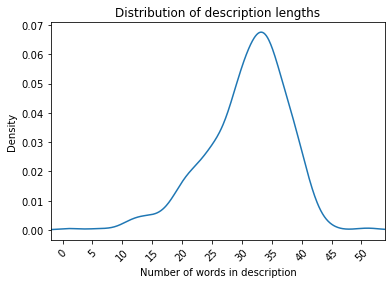

In [25]:
# Plot distribution of description length  
# Most descriptions are in the range mean description length +- 10 words (no long tails)
df_clean['description_length'].plot.kde()
plt.xticks(np.arange(0, max_descr_len+1, 5), rotation=45)
plt.xlim(xmax = max_descr_len+2, xmin = -2)
plt.xlabel("Number of words in description")
plt.title("Distribution of description lengths")
plt.show()

In [26]:
# Exclude the shows that have basically no description (check for threshold of 10, 15, and 20 words)
df_clean_10 = df_clean[df_clean['description_length'] > 10]
df_clean_15 = df_clean[df_clean['description_length'] > 15]
df_clean_20 = df_clean[df_clean['description_length'] > 20]

# Check how many of the shows are left when using each minimum word count threshold
n_clean = len(df_clean)
n_descr_10 = len(df_clean_10)
n_descr_15 = len(df_clean_15)
n_descr_20 = len(df_clean_20)

print("The number of shows with description of more than 10 words is: ", n_descr_10, 
      ", which fraction is ", "{:.2f}".format(n_descr_10/n_clean) , " of all shows")
print("The number of shows with description of more than 15 words is: ", n_descr_15, 
      ", which fraction is ", "{:.2f}".format(n_descr_15/n_clean) , " of all shows")
print("The number of shows with description of more than 20 words is: ", n_descr_20, 
      ", which fraction is ", "{:.2f}".format(n_descr_20/n_clean) , " of all shows")

The number of shows with description of more than 10 words is:  1131 , which fraction is  1.00  of all shows
The number of shows with description of more than 15 words is:  1103 , which fraction is  0.97  of all shows
The number of shows with description of more than 20 words is:  1047 , which fraction is  0.92  of all shows


In [27]:
# In all these three cases there are more than 90% of the shows kept in the data, so
# I will continue with the shows with descriptions longer than 20 words because 
# more words means better inferences for content-based recommendations
df_clean = df_clean_20.copy()

In [28]:
# Reindex df_clean and add a column with unique id for each show,
# which will be used to uniquely refer to a specific show
df_clean = df_clean.reset_index(drop=True)
df_clean['id'] = range(len(df_clean))

In [29]:
# Save the cleaned data to .csv file
df_clean.to_csv(os.path.join(folder_path, 'clean_data.csv'), index=False, sep=',')

### Further data exploration

In [30]:
# Load clean data file from disk
folder_path = os.path.join(os.getcwd(), 'ABC')
df_clean = pd.read_csv(os.path.join(folder_path, 'clean_data.csv'), sep=',')

In [31]:
# Inspect if clean data is correctly loaded
df_clean.head()

,title,description,genre,website_url,image_url,description_length,id
0,100 Bloody Acres,Organic fertilizer producers and brothers are ...,"Comedy, Drama, Movies",https://iview.abc.net.au/show/100-bloody-acres...,https://cdn.iview.abc.net.au/thumbs/i/zw/ZW297...,36,0
1,13 Assassins,When the sadistic excesses of Lord Matsudaira ...,"Drama, Movies",https://iview.abc.net.au/show/13-assassins/vid...,https://cdn.iview.abc.net.au/thumbs/i/zw/ZW284...,38,1
2,199 Little Heroes,The journey to school is a very special type o...,Education,https://iview.abc.net.au/show/199-little-heroes,https://cdn.iview.abc.net.au/thumbs/i/zw/publi...,45,2
3,30 Days Of Night,After an Alaskan town is plunged into darkness...,"Drama, Movies",https://iview.abc.net.au/show/30-days-of-night...,https://cdn.iview.abc.net.au/thumbs/i/zw/ZW285...,39,3
4,7.30 Special: The Property Market,"In a 7.30 Special, Alan Kohler reports on hous...",News and current affairs,https://iview.abc.net.au/show/7-30-special-the...,https://cdn.iview.abc.net.au/thumbs/i/ns/NS217...,32,4


In [32]:
# Check distribution of number of shows per genre (combination)
genre_counts = df_clean.genre.value_counts()
genre_frequencies = df_clean.genre.value_counts(normalize=True)
genre_count_freq = pd.concat([genre_counts, genre_frequencies], axis=1, 
                             keys=['count', 'frequency'])

In [33]:
genre_count_freq

,count,frequency
Education,118,0.112703
Kids,113,0.107927
Drama,104,0.099331
"Drama, Movies",102,0.097421
Documentary,86,0.082139
News and current affairs,69,0.065903
Comedy,66,0.063037
Family,64,0.061127
Arts and culture,47,0.044890
"Documentary, Family",36,0.034384


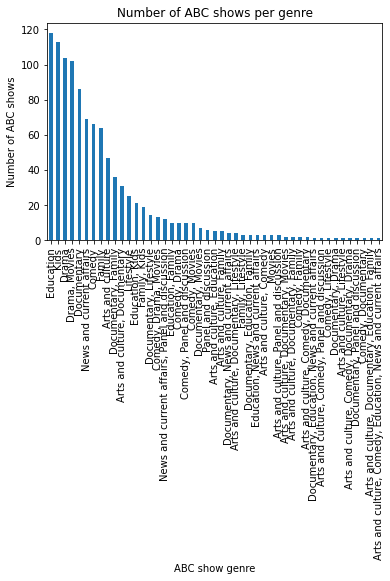

In [34]:
# Make visualisation of the distribution of shows (with description length > 20 words) over genres
genre_counts.plot.bar()
plt.title('Number of ABC shows per genre')
plt.ylabel('Number of ABC shows')
plt.xlabel('ABC show genre')
plt.show()

All main genres contain more than 10 shows so could always recommend something of their own genre. Some genres are much more frequently occuring than others though so may give better suited recommendations (as more to choose from) when not going for diverse recommendations. With regards to specific combinations of genres, some contain almost no shows so clustering shows based on this won't give good results. Instead K-Means clustering will group shows that are similar in content.

In [35]:
# Check description length statistics distribution over genres 
# (of shows with description length > 20 words)
grouped_genre = df_clean.groupby('genre')
genre_min_length = grouped_genre.min('min')
genre_max_length = grouped_genre.max('max')
genre_mean_length = grouped_genre.mean('mean')
genre_median_length = grouped_genre.median('median')

In [36]:
# Concatenate all statistics into one dataframe and inspect it
genre_length_stat = pd.concat([genre_min_length, genre_max_length, genre_mean_length, 
                               genre_median_length], axis=1, keys=['min', 'max', 'mean', 'median'])
genre_length_stat

min        \
                                                   description_length    id   
genre                                                                         
Arts and culture                                                   23    71   
Arts and culture, Comedy                                           30    74   
Arts and culture, Comedy, Documentary                              28    60   
Arts and culture, Comedy, Documentary, Drama                       34   784   
Arts and culture, Comedy, Education, News and c...                 31   160   
Arts and culture, Comedy, Panel and discussion                     38   165   
Arts and culture, Documentary                                      23    10   
Arts and culture, Documentary, Education, Family                   35  1006   
Arts and culture, Documentary, Family                              33    55   
Arts and culture, Documentary, Lifestyle                           24   221   
Arts and culture, Documentary, Movies                              25   726   
Arts and culture, Education                                        24   262   
Arts and culture, Family                                           31   208   
Arts and culture, Lifestyle                                        31   871   
Arts and culture, Panel and discussion                             25   110   
Comedy                                                             21     7   
Comedy, Documentary                                                36   550   
Comedy, Drama                                                      21    36   
Comedy, Drama, Movies                                              29     0   
Comedy, Family                                                     33   417   
Comedy, Lifestyle                                                  31   407   
Comedy, Movies                                                     22    33   
Comedy, Panel and discussion                                       29    37   
Documentary                                                        21     8   
Documentary, Drama                                                 26   602   
Documentary, Education, Family                                     29   130   
Documentary, Education, News and current affairs                   22   427   
Documentary, Family                                                21    68   
Documentary, Lifestyle                                             24    76   
Documentary, Movies                                                30   197   
Documentary, News and current affairs                              36    94   
Documentary, Panel and discussion                                  37   102   
Drama                                                              21    35   
Drama, Movies                                                      21     1   
Education                                                          21     2   
Education, Family                                                  21    64   
Education, Kids                                                    21    31   
Education, News and current affairs                                32   191   
Family                                                             22     6   
Family, Kids                                                       30    40   
Family, Lifestyle                                                  33   423   
Kids                                                               21    11   
Lifestyle                                                          22   101   
Movies                                                             31    51   
News and current affairs                                           25     4   
News and current affairs, Panel and discussion                     25    43   
Panel and discussion                                               27    91   

                                                                  max        \
                                    

All statistics are relatively similar (also for the genres with the higher maximum description lengths), so the description lengths won't influence much on how well a genre will be represented in recommendations. But note that here all combinations of genres that exist are written down so sometimes this may only be applicable to a few shows so more dependent on those.

### Data pre-processing

In [37]:
def tokenize(df_column=None, processed_texts = [], remove_punctuation=True, 
             to_lowercase=True, stop_words=[], word_types=[], to_lemma=True):
    """
    Tokenizes the text entries in df_column using spacy tokenizer 
    and filters this on supplied arguments, or processes the already
    tokenized texts of processed_texts further
    
    Parameters
    ----------
    df_column : pandas Series object (default None)
        Series with texts that need to be tokenized.
        If None is supplied, then processed_texts needs to be given to process that
        one further using the other arguments instead of tokenizing df_column from the start
    processed_texts : list of list of str (default [])
        List of tokenized texts that need to be further processed using the other arguments.
        If this is supplied, then df_column needs to be None
    remove_punctuation : bool (default True)
        Boolean stating if punctuation needs to be removed from the tokenized texts
    to_lowercase : bool (default True)
        Boolean stating if the tokenized texts need to be lowercased
    stop_words : list of str (default [])
        List with (lowercased) stop words to remove from the tokenized texts,
        with the default being no words to remove
    word_types : list of str (default [])
        List with word types to keep from the tokenized texts, which have to be
        one or multiple of the POS tags of Spacy (e.g. see here for examples
        https://machinelearningknowledge.ai/tutorial-on-spacy-part-of-speech-pos-tagging/)
    to_lemma : bool (default True)
        Boolean stating if the tokenized texts need to be lemmatized

        
    Returns
    -------
    raw_processed_texts : list of lists of str
        List with a list of tokenized words per data entry in df_column.
        This is a raw processed texts without taking the other arguments into
        account, such that still multiple different processing methods on the tokens can
        be done without needing to tokenize the full df_column anew
    processed_texts : list of lists of str
        List with a list of tokenized words per data entry in df_column. 
        This is the fully processed texts that take all arguments into account
        to reach the desired tokenization result
    """
    # Preprocess dataset using Spacy tokenizer on texts in df_column, unless None is given,
    # then proceed by further processing the already supplied tokenized texts
    if df_column is not None:
        nlp = spacy.load("en_core_web_sm")
        processed_texts = [text for text in tqdm(nlp.pipe(df_column.values, 
                                                          disable=['ner', 'parser']),
                                                      total=len(df_column.values))]  
    
    # Remove spaces that are presented as an empty string 
    processed_texts = [[word for word in processed_text if not word.text.isspace()] 
                       for processed_text in processed_texts]
    
    raw_processed_texts = processed_texts.copy()
    
    # Remove punctuation if wanted
    if remove_punctuation:
        processed_texts = [[word for word in processed_text if not word.is_punct] 
                           for processed_text in processed_texts]
        
    # Remove the given stopwords if the list is not empty
    if stop_words:
        processed_texts = [[word for word in processed_text if not word.text in stop_words] 
                           for processed_text in processed_texts]
        
    # Filter on given word types if the list is not empty, e.g. 
    # proper nouns ('PROPN'), verbs ('VERB'), nouns ('NOUN') and adjectives ('ADJ')  
    if word_types:
        processed_texts = [[word for word in processed_text if word.pos_ in word_types] 
                           for processed_text in processed_texts]
    
    # Keep only lemmatized words if wanted
    if to_lemma:
        processed_texts = [[word.lemma_ for word in processed_text] 
                           for processed_text in processed_texts]
        
    # Lowercase the text if wanted. When it is lemmatized already, then each item is a string so directly
    # apply .lower() on it, and if it still is a token, then need to apply .text.lower().
    # Perform this as last step because the previous steps still require the spacy tokens
    if to_lowercase:
        processed_texts = [[word.lower() if isinstance(word, str) else word.text.lower() for word in processed_text] 
                           for processed_text in processed_texts]
    
    return raw_processed_texts, processed_texts

In [38]:
# Use standard list of English stopwords
stop_list = list(text.ENGLISH_STOP_WORDS)

In [39]:
# Tokenize all the descriptions of shows, which can later be subsetted into different sets of shows to compare. 
# This prevents duplicated tokenizing of descriptions when subsets overlap, which would take unneccessary computing power.
# Additionally, raw_processed_descr can be further processed in different preprocessing ways, than is 
# applied on processed_descr below, as it is still the raw tokenized text. These can then also be compared with each other.
# Add the genre label also to the plot as additional input for the tokenizer to use for the clusters later on 
# (as same genre entails more similar shows with respect to their type)
raw_processed_descr, fully_processed_descr = tokenize(df_column=df_clean.description+' '+df_clean.genre, 
                                                      processed_texts = [], 
                                                      remove_punctuation=True, 
                                                      to_lowercase=True, stop_words=stop_list, 
                                                      word_types=['PROPN', 'VERB', 'NOUN', 'ADJ'], 
                                                      to_lemma=True)

  0%|          | 0/1047 [00:00<?, ?it/s]

In [41]:
def vectorize_data(X, vectorizer = 'tf-idf', MIN_DF=5, MAX_DF=0.75):
    """
    Creates the vectorized data for e.g. performing k-means clustering.
    For this it uses already tokenized texts, which it vectorizes using a count or
    tf-idf vectorizer
    
    Parameters
    ----------
    X : list of lists of str
        List with a list of tokenized words per data entry, which will be vectorized.
        When a count vectorizer is used, make sure to have fully processed the texts
        already, while with the use of a tf-idf vectorizer no stop words etc. have to
        be removed beforehand as these will have a too high document frequency to
        be considered important words
    vectorizer : str (default 'tf-idf')
        String stating which kind of vectorization needs to be applied on X: 
        'count' for count vectorization, which simply counts how often a word occurs
        in each data entry
        'tf-idf' for TF-IDF vectorization, which weights how often a word occurs in
        other data entries as well to reflect how important a word is for a specific data entry
    MIN_DF : int (default 5)
        Minimum document frequency: the word should occur in at least MIN_DF 
        number of data entries
    MAX_DF : double (default 0.75)
        Maximum document frequency: the word should not occur in more than MAX_DF 
        fraction of the data entries
        
    Returns
    -------
    X_vect : list of lists of int
        List with the vectorized data entries for the dataset
    vocabulary : list of str
        List with the unique words occuring in the dataset 
    """    
    # Use a count vectorizer on the already tokenized texts
    if vectorizer == 'count':
        cv_spacy = CountVectorizer(tokenizer= lambda x:x, preprocessor=lambda x:x,
                     min_df=MIN_DF, max_df=MAX_DF) 
        X_vect = cv_spacy.fit_transform(X)
        vocabulary = cv_spacy.get_feature_names()
        
    # Use a TF-IDF vectorizer on the already tokenized texts
    elif vectorizer == 'tf-idf':
        tfidf = TfidfVectorizer(tokenizer= lambda x:x, preprocessor=lambda x:x,
                                min_df=MIN_DF, max_df=MAX_DF) 
        tfidf.fit(X) # create the vocabulary
        X_vect = tfidf.transform(X)
        vocabulary = tfidf.get_feature_names() # The newer function .get_feature_names_out() needs scikit-learn > 1.0
    else:
        print("Choose one of the vectorization options: 'count' or 'tf-idf'")
        X_vect = X.copy()
        
    return X_vect, vocabulary

In [42]:
# Check sklearn version, when higher than 1.0 then tfidf needs an updated function
# import sklearn
# print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [43]:
# Vectorize the tokenized descriptions using TF-IDF
# Min and Max df don't really matter for tf-idf as will scale it anyways.
# However, use min_df=0 instead of e.g. 5 for if there are less than that number of shows with 
# some diverser representation of communities, like aboriginals)
X_vect, vocabulary = vectorize_data(
        X=fully_processed_descr, vectorizer = 'tf-idf', MIN_DF=0, MAX_DF=0.9) 

C:\Users\sande\Anaconda3\envs\Data_wrangling\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [44]:
X_vect # Check size of matrix with tf-idf values

<1047x5332 sparse matrix of type '<class 'numpy.float64'>'
	with 19331 stored elements in Compressed Sparse Row format>

In [45]:
print("Total number of words in vocabulary of all show descriptions is: ", len(vocabulary))

Total number of words in vocabulary of all show descriptions is:  5332


### Data clustering

In [46]:
# Determine an optimal number of clusters for KMeans using the elbow technique:
# run K-Means for a range of K and determine where the 'elbow' is of distortions.
# There are 11 main genres so probably best to take that as minimum number of clusters
# Code inspired by https://predictivehacks.com/k-means-elbow-method-code-for-python/
distortions = []
K = range(1,50)
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_vect)
    distortions.append(kmeanModel.inertia_)

  0%|          | 0/49 [00:00<?, ?it/s]

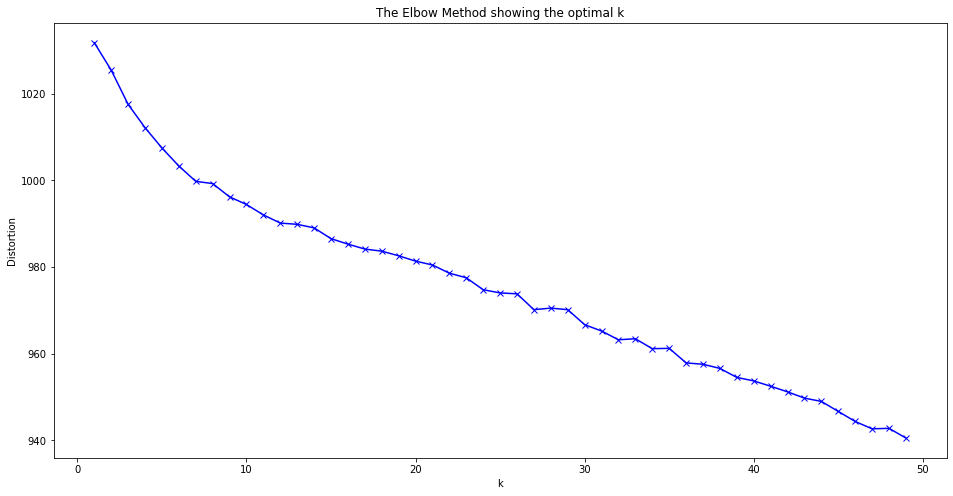

In [47]:
# Plotting the distortions of K-Means, from which the elbow can visually be determined
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The optimal number of clusters for K-Means is chosen to be 15 from the above plot, because less than 11 would be less than the total number of genres (but much more wouldn't make sense either because questionable on what is then clustered, getting too specific probably), and if it are too many clusters then only a small number of shows is included per cluster (1047 shows in total). With 15 clusters there on average are 70 shows per cluster (and some of the genres with many shows are likely split up into more specific subgenres by having a few more clusters than genres). This plot is just decreasing the whole time, which doesn't seem to decrease much in slope like theoretically this elbow method would work.  

In [48]:
# Perform K-means clustering to get clusters with similar shows
# Code adjusted from analysis.ipynb of streamlit example (provided by teachers of the course)
n_clusters = 15  # This is the used K determined above
kmeanModel = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=3000, random_state=0)
mod = kmeanModel.fit_transform(X_vect)
df_clean['k_means_cluster'] = kmeanModel.predict(X_vect)

In [49]:
# Inspect words corresponding to the generated clusters
# Code adjusted from analysis.ipynb of streamlit example (provided by teachers of the course)
order_centroids = kmeanModel.cluster_centers_.argsort()[:, ::-1]
dict = []
for i in range(n_clusters):
    print('%d' % i, sep='', end=', '),
    for ind in order_centroids[i, :10]:
        print(vocabulary[ind], sep='', end=', ')
    print('')

0, drama, movie, life, young, base, love, novel, find, man, woman, 
1, comedy, panel, discussion, stand, world, family, series, documentary, return, know, 
2, family, documentary, attenborough, david, science, life, climate, challenge, human, australia, 
3, child, tell, education, history, story, live, family, documentary, people, drama, 
4, news, current, affair, panel, discussion, australian, australia, australians, story, program, 
5, drama, old, murder, life, secret, change, crime, town, movie, year, 
6, series, book, kids, family, adventure, little, time, base, beach, school, 
7, play, school, kid, emma, special, join, episode, space, matt, dog, 
8, news, abc, affair, current, bring, reporting, story, today, original, present, 
9, kid, friend, adventure, new, love, family, good, lah, world, old, 
10, drama, movie, story, come, world, great, scientist, documentary, writer, idea, 
11, stage, education, english, geography, science, pdhpe, series, world, use, early, 
12, lifestyle, ge

In [50]:
# Code from 02-TF-IDF with K-means clustering.ipynb (provided by teachers of the course).
# and I added documentation
def plot(dense_tfidf, k):
    """
    Reduces the dense_tfidf data to a dimensionality of 2, trains a K-Means clustering
    model on it with k clusters, and creates a 2D visualisation out of its results. 
    This way the clustering results of higher dimension data can be visually inspected 
    
    Parameters
    ----------
    dense_tfidf : matrix of numerical values
        List with the vectorized data entries for the dataset (e.g. tf-idf values), 
        for which its sparse matrix is converted into a dense matrix
    k : int 
        Number of clusters to create using K-Means clustering
    """    
        h = 0.2
        reduced_data = PCA(n_components=2).fit_transform(dense_tfidf)

        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit(reduced_data)

        x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
        y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)

        plt.figure(1)
        plt.clf()
        plt.imshow(Z, interpolation='nearest',
                   extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                   cmap=plt.cm.Paired,
                   aspect='auto', origin='lower')

        centroids = kmeans.cluster_centers_
        plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
        plt.scatter(centroids[:, 0], centroids[:, 1],
                    marker='x', s=169, linewidths=3,
                    color='r', zorder=10)
        plt.title('K-means clustering of ABC iview shows')

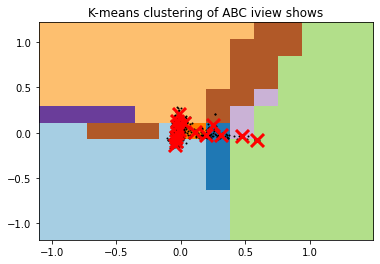

In [51]:
# Code adjusted from 02-TF-IDF with K-means clustering.ipynb (provided by teachers of the course)

# Visualise KMeans clusters in 2D (so reduce its dimensionality)
d_matrix = dok_matrix(X_vect).todense()

plot(dense_tfidf=d_matrix, k=n_clusters)

In [52]:
# Check if clusters make sense by displaying some show titles belonging to clusters
df_clean[df_clean['k_means_cluster'] == 0]['title'].head(10)

0                            100 Bloody Acres
1                                13 Assassins
38                                 Adaptation
39                                  Adoration
54                      An Accidental Soldier
56     And When Did You Last See Your Father?
59                                      Angel
96                                 Auto Focus
105                                 Ballerina
114                              Bed Of Roses
Name: title, dtype: object

In [53]:
# Inspect dataset that now contains cluster numbers
df_clean.head() 

,title,description,genre,website_url,image_url,description_length,id,k_means_cluster
0,100 Bloody Acres,Organic fertilizer producers and brothers are ...,"Comedy, Drama, Movies",https://iview.abc.net.au/show/100-bloody-acres...,https://cdn.iview.abc.net.au/thumbs/i/zw/ZW297...,36,0,0
1,13 Assassins,When the sadistic excesses of Lord Matsudaira ...,"Drama, Movies",https://iview.abc.net.au/show/13-assassins/vid...,https://cdn.iview.abc.net.au/thumbs/i/zw/ZW284...,38,1,0
2,199 Little Heroes,The journey to school is a very special type o...,Education,https://iview.abc.net.au/show/199-little-heroes,https://cdn.iview.abc.net.au/thumbs/i/zw/publi...,45,2,11
3,30 Days Of Night,After an Alaskan town is plunged into darkness...,"Drama, Movies",https://iview.abc.net.au/show/30-days-of-night...,https://cdn.iview.abc.net.au/thumbs/i/zw/ZW285...,39,3,5
4,7.30 Special: The Property Market,"In a 7.30 Special, Alan Kohler reports on hous...",News and current affairs,https://iview.abc.net.au/show/7-30-special-the...,https://cdn.iview.abc.net.au/thumbs/i/ns/NS217...,32,4,4


In [54]:
# Save the data with clusters to .csv file
df_clean.to_csv(os.path.join(folder_path, 'clustered_shows.csv'), index=False, sep=',')

### Distance between shows using (public) values

In [56]:
# Create vocabularity with tokens describing minority/oppressed groups to be able to infer 
# from description tokens if a show is likely to enhance representation diversity.
# This specifically also contains the word 'aboriginal', which is a relevant community for Australia.
# Note that words like black and brown don't have to refer to person's skin colour but may also be about 
# some random object (as tokens don't include context), which may give wrong annotations of shows being diverse.
# Words are from following sources and own additional brainstorm:
# https://openstax.org/books/introduction-sociology-3e/pages/11-1-racial-ethnic-and-minority-groups
# https://www.cosmopolitan.com/sex-love/a24442815/sexual-orientation-list-definitions/
# https://www.sciencedirect.com/science/article/pii/B9780080449104007756
# https://view.officeapps.live.com/op/view.aspx?src=https%3A%2F%2Fwww2.ohchr.org%2Fenglish%2Fissues%2Fminorities%2Fdocs%2FWP2.doc&wdOrigin=BROWSELINK
diversity_words = ['race', 'racial', 'racism', 'racist', 'ethnic', 'ethnicity', 'black', 'brown', 'bipoc', 'indigenous',
                   'asian', 'african', 'african-american', 'native', 'aboriginal', 'arabic', 'arab',
                   'lgbt', 'lgbt+', 'lgbtq', 'lgbtq+', 'lgbti', 'lgbti+', 'lgb',
                   'lesbian', 'gay', 'homo', 'homosexual', 'bi', 'bisexual', 'trans', 'transgender',
                   'transsexual', 'non-binary', 'agender', 'asexual', 'aromantic', 'intersex', 'intersexual',
                   'queer', 'pansexual', 'heteronormative', 'polyamorous', 'demisexual',
                   'disability', 'disabled', 'religion', 'muslim', 'jew', 'jewish', 'immigrant', 'refugee', 'asylum',
                   'minority', 'oppressed', 'oppression', 'marginalised', 'colonialism', 'colony', 'homeless'] 

# Make a sublist of diversity_words that are included in the vocabulary of the dataset 
diversity_words_included = []
for word in diversity_words:
    if word in vocabulary: 
        print(f'The word \033[4m{str(word)}\033[0m is contained in the vocabulary')
        
        # Add word to list with all included diversity words because it is in the vocabulary
        diversity_words_included.append(word) 
    else:
        print(f'The word \033[4m{str(word)}\033[0m is \033[1m not \033[0m contained in the vocabulary')
        
print('\nDiversity words included in the vocabulary are (', len(diversity_words_included), 
      ' of ', len(diversity_words), ') :\n', diversity_words_included)

The word race is contained in the vocabulary
The word racial is contained in the vocabulary
The word racism is contained in the vocabulary
The word racist is contained in the vocabulary
The word ethnic is  not  contained in the vocabulary
The word ethnicity is  not  contained in the vocabulary
The word black is contained in the vocabulary
The word brown is contained in the vocabulary
The word bipoc is  not  contained in the vocabulary
The word indigenous is contained in the vocabulary
The word asian is  not  contained in the vocabulary
The word african is contained in the vocabulary
The word african-american is  not  contained in the vocabulary
The word native is  not  contained in the vocabulary
The word aboriginal is contained in the vocabulary
The word arabic is contained in the vocabulary
The word arab is  not  contained in the vocabulary
The word lgbt is  not  contained in the vocabulary
The word lgbt+ is  not  contained in the vocabulary
The word lgbtq is  not  contained in the v

In [57]:
# Create a list with show ids that contain one or more of the representation words in their tokens
closest_representation_id = []
for i, tokens in enumerate(fully_processed_descr):
    # Check if the tokens contain any of the representation diversity words (that are in the vocabulary)
    if any(item in tokens for item in diversity_words_included):
        closest_representation_id.append(i)

In [58]:
# Check how many shows are included in the list with representation diversity shows
print("There are ", len(closest_representation_id), 
      " shows in the ABC iview dataset that contain a representation diverse word in their description.")

There are  73  shows in the ABC iview dataset that contain a representation diverse word in their description.


In [59]:
 # List 10 show titles with representation diversity
df_clean.iloc[closest_representation_id]['title'].head(10)

7                                      8MMM
12              ABC Education Good Mornings
42            Advice To My 12 Year Old Self
50                All My Friends Are Racist
118    Being Frank: The Frank Gardner Story
138                            Black Comedy
153      Boyer Lecture 2019: Rachel Perkins
162                        The Broken Shore
174                                  Buried
182                   Can We Save The Reef?
Name: title, dtype: object

In [60]:
# Show snippet of the descriptions of above titles
df_clean.iloc[closest_representation_id]['description'].head(10) 

7      An Indigenous crew from a remote radio station...
12     How would you greet someone in the language of...
42     A range of talented Australians, including som...
50     In a survival-of-the-fiercest, two twenty-some...
118    Sixteen years after being shot by Al-Qaeda, br...
138    A sketch comedy show by Blackfellas, for every...
153    Multi award-winning filmmaker and Arrernte/Kal...
162    An evocative crime thriller set against a back...
174    Paul Conroy is not ready to die but when he wa...
182    An epic story of Australian and international ...
Name: description, dtype: object

In [62]:
def cosine_distance(vector_a, vector_b):
    """
    Compute pairwise cosine distances between vector_a and vector_b (may both contain multiple show vectors).
    This applies the following formula:    
    a . b  -> dot(a, b)
    -----
    |a||b| -> norm(a) * norm(b)
    
    where dot(a,b) is computed using a linear_kernel of sklearn to be able to handle a sparse matrix,
    and the denominator is left out because tf-idf values are already normalized.
    
    Code based on https://stackoverflow.com/questions/12118720/python-tf-idf-cosine-to-find-document-similarity
    
    Parameters
    ----------
    vector_a : sparse matrix of normalized numerical values
        List with the vectorized data entries for the dataset (tf-idf values), 
        for which its sparse matrix is used as the reference show for which
        to compute distances to vector_b to.
    vector_b : sparse matrix of normalized numerical values
        List with the vectorized data entries for the dataset (tf-idf values), 
        for which its sparse matrix is used as the referenced show(s) for which
        to compute distances from vector_a to.
        
    Returns
    -------
    distances : list with numerical values
        List with cosine distances from vector_a to show(s) in vector_b, in the order
        of vector_b
    """    
    
    return linear_kernel(vector_a, vector_b).flatten() 

In [63]:
def find_closest_shows(vector_a, vector_b_list, vector_b_ids, n_shows=10):
    """
    For vector_a find the top n_shows number of shows from vector_b_list that are
    most similar in content based on cosine distance.
    Note: make sure that vector_a is not included in vector_b_list as otherwise that 
    one will be the closest returned show of course
    
    Code inspired by https://stackoverflow.com/questions/12118720/python-tf-idf-cosine-to-find-document-similarity
    
    Parameters
    ----------
    vector_a : sparse matrix of normalized numerical values
        List with the vectorized data entries for the dataset (tf-idf values), 
        for which its sparse matrix is used as the reference show for which
        to compute distances to vector_b to.
    vector_b_list : sparse matrix of normalized numerical values
        List with the vectorized data entries for the dataset (tf-idf values), 
        for which its sparse matrix is used as the referenced show(s) for which
        to compute distances from vector_a to. 
    vector_b_ids : list of int
        List in the same order as the shows in vector_b_list which contains the
        unique ids referencing its shows. This is used to be able to correctly 
        link a retrieved distance with the show in question. If this is not done, 
        then just indices will be returned relative to the slice of rows given in 
        vector_b_list instead of the actual ids of shows
        
    Returns
    -------
    closest_show_indices : list of int
        Ordered list with the indices of the top n_shows number of shows that
        are closest to the show of vector_a, ordered from most to least similar
    closest_distances : list of numerical values
        Ordered list in the same order as closest_show_indices with its corresponding
        cosine distance between the show of vector_a and the corresponding show of
        vector_b_ids
    """    
    # Compute the cosine distance between vector_a and the shows in vector_b_list
    distances = cosine_distance(vector_a, vector_b_list)     
    
    # Get the vector_b_list indices of top n_shows shows that are indexed relative to 
    # vector_b_list (need +1 else get one show too little) 
    # Ordered from big to small (most to least similar) 
    closest_indices = distances.argsort()[:-(n_shows+1):-1]     
    
    # Retrieve the corresponding distances of the top_n shows
    closest_distances = distances[closest_indices] 
    
    # Get the unique show ids corresponding to the closest shows to be able to retrieve
    # information about these shows from the dataframe
    closest_show_indices = [vector_b_ids[i] for i in closest_indices]    
    
    # Return the ids and distances of n_shows closest shows to vector_a
    return closest_show_indices, closest_distances  

In [64]:
# Create a list with lists of indices of vectors that belong to which K-Means cluster
cluster_indices = []
for i in range(n_clusters):
    indices = df_clean[df_clean.k_means_cluster == i]['id']
    cluster_indices.append(indices)

In [65]:
# Check how many items are contained in each cluster
for i, cluster in enumerate(cluster_indices):
    print("Cluster ", i, " contains ", len(cluster), " shows")

Cluster  0  contains  90  shows
Cluster  1  contains  113  shows
Cluster  2  contains  66  shows
Cluster  3  contains  103  shows
Cluster  4  contains  63  shows
Cluster  5  contains  71  shows
Cluster  6  contains  50  shows
Cluster  7  contains  33  shows
Cluster  8  contains  32  shows
Cluster  9  contains  117  shows
Cluster  10  contains  67  shows
Cluster  11  contains  70  shows
Cluster  12  contains  41  shows
Cluster  13  contains  107  shows
Cluster  14  contains  24  shows


In [66]:
# For each show determine the top 10 most content similar shows from its own cluster
# (within cluster/ personalized recommendations), from a different cluster (outside cluster/
# content diverse recommendations), and from the list of shows which represent minority/ 
# oppressed groups (representation diverse recommendations)

closest_within_cluster = [] 
closest_outside_cluster = []
closest_representation = []

# Loop through the tf-idf values of each show (which are based on its description and genre label(s))
for i, vector in tqdm(enumerate(X_vect), total=X_vect.shape[0]):
    # Check in which cluster this vector belongs (the unique ids of shows correspond to the indices of X_vect)
    for j, indices in enumerate(cluster_indices):
        if i in indices:
            # Get the indices of shows from the cluster this vector belongs to
            own_cluster = list(indices.copy()) 
            
            # Store index of cluster this vector belongs to
            n_cluster = j
            
            # No need to continue checking the other clusters if this index is in that one, so break
            break 
    
    # Remove index of the current vector from list of its cluster (no need to compute the distance to itself)
    own_cluster.remove(i) 
    
    # Merge the indices of shows in other clusters to one list that is used for content diversity
    other_cluster = cluster_indices[:n_cluster] + cluster_indices[n_cluster+1:] # Does not include own_cluster
    other_cluster = [ind for cluster in other_cluster for ind in cluster] # Flatten list of list if cluster indices
    
    # Find closest shows within cluster
    closest_ind_within, closest_dist_within = find_closest_shows(vector_a=vector, 
                                                    vector_b_list=X_vect[own_cluster],
                                                    vector_b_ids=list(df_clean.iloc[own_cluster]['id']), 
                                                    n_shows=10)
    # Add row with own vector index, index of top closest show, and the cosine distance between them
    for ind, dist in zip(closest_ind_within, closest_dist_within):
        closest_within_cluster.append([i, ind, dist]) 
        
    # Find closest shows outside of cluster (for content diversity)
    closest_ind_outside, closest_dist_outside = find_closest_shows(vector_a=vector, 
                                                    vector_b_list=X_vect[other_cluster], 
                                                    vector_b_ids=list(df_clean.iloc[other_cluster]['id']), 
                                                    n_shows=10)
    # Add row with own vector index, index of top closest show, and the cosine distance between them
    for ind, dist in zip(closest_ind_outside, closest_dist_outside):
        closest_outside_cluster.append([i, ind, dist]) 
        
    # Remove index of this vector from list of diversity representation shows if it exists in there 
    # (no need to compute the distance to itself)
    closest_repr = closest_representation_id.copy()
    if i in closest_representation_id:
        closest_repr.remove(i)
    
    # Find closest shows from list of shows representing minority/oppressed groups (for representation diversity)
    closest_ind_repr, closest_dist_repr = find_closest_shows(vector_a=vector, 
                                                    vector_b_list=X_vect[closest_repr], 
                                                    vector_b_ids=list(df_clean.iloc[closest_repr]['id']), 
                                                    n_shows=10)
    # Add row with own vector index, index of top closest show, and the cosine distance between them
    for ind, dist in zip(closest_ind_repr, closest_dist_repr):
        closest_representation.append([i, ind, dist]) 

  0%|          | 0/1047 [00:00<?, ?it/s]

In [67]:
# Create dataframes from the lists, which contain the top 10 similar shows for each show
df_closest_within_cluster = pd.DataFrame(closest_within_cluster, 
                                         columns=['id_a', 'id_b', 'cosine_distance'])
df_closest_outside_cluster = pd.DataFrame(closest_outside_cluster, 
                                          columns=['id_a', 'id_b', 'cosine_distance'])
df_closest_representation = pd.DataFrame(closest_representation, 
                                         columns=['id_a', 'id_b', 'cosine_distance'])

In [68]:
# Inspect dataframes
df_closest_within_cluster.head(11)

,id_a,id_b,cosine_distance
0,0,891,0.093436
1,0,528,0.086951
2,0,949,0.077987
3,0,174,0.076079
4,0,962,0.075341
5,0,177,0.062155
6,0,161,0.059601
7,0,646,0.053741
8,0,684,0.052728
9,0,767,0.051706


In [69]:
# As can be seen here, some shows in another cluster may be closer than shows from own cluster 
# (compare with previous table)
df_closest_outside_cluster.head(11) 

,id_a,id_b,cosine_distance
0,0,882,0.120220
1,0,436,0.112071
2,0,390,0.094753
3,0,157,0.093246
4,0,100,0.087460
5,0,1040,0.085057
6,0,235,0.084896
7,0,937,0.084491
8,0,770,0.083401
9,0,51,0.082889


In [70]:
# As can be seen here, there can be duplicates where another representation diverse show is close enough 
# to show up in the top 10 of within or outside cluster shows (compare with previous tables)
df_closest_representation.head(11) 

,id_a,id_b,cosine_distance
0,0,868,0.078316
1,0,174,0.076079
2,0,7,0.060740
3,0,296,0.052115
4,0,360,0.037424
5,0,875,0.035542
6,0,242,0.035031
7,0,138,0.032561
8,0,930,0.028077
9,0,540,0.027286


In [71]:
# Save the data with closest show ids to .csv files
df_closest_within_cluster.to_csv(os.path.join(folder_path, 'closest_within_cluster.csv'), 
                                 index=False, sep=',')
df_closest_outside_cluster.to_csv(os.path.join(folder_path, 'closest_outside_cluster.csv'), 
                                  index=False, sep=',')
df_closest_representation.to_csv(os.path.join(folder_path, 'closest_representation.csv'), 
                                 index=False, sep=',')